<h1 style='text-align:center; font-size:30px; font-weight:bold; '>Fine-Tuning Distilbert on the FinancialPhraseBank Dataset</h1>

# 1. Introduction

Training large language models from scratch has become increasingly resource-intensive. This project explores whether transfer learning—the process of adapting pre-trained models to downstream tasks—can serve as a viable, cost-effective alternative in financial sentiment analysis.

Using DistilBERT, a compact transformer trained on general English corpora, a series of progressively flexible fine-tuning strategies are tested to determine how far task-specific adaptation can go in closing the gap with domain-specialized models.

This study aims to identify which strategies offer the best balance between computational efficiency, model accuracy, and generalization in financial NLP tasks.

> **Note:**  
> It is recommended to run this project on a GPU for training efficiency. All experiments were conducted using the free GPU resources provided by Google Colab.


# Table of Contents

1. **Introduction and Objective**

2. **Exploratory Data Analysis (EDA)**

3. **Training Classifier Head Only**
   - 3.1 Experiment 1: Model Preformance Across Varying Subsets ([Subset Fine-Tuning Experiments](./experiments/3.1_subset_finetune.ipynb))
   - 3.2 Experiment 2: Addressing Class Imbalance ([Class Imbalance Experiments](./experiments/3.2_class_imbalance_experiments.ipynb))
   - 3.3 Aside: Working with TFDS - TensorFlow Datasets ([TFDS Demonstration](./experiments/3.3_TFDS_alternative.ipynb))

4. **Supervised Fine-Tuning with Fixed Classifier Head**
   - 4.1 Load Trained Model, Freeze Classifier Head, Unfreeze Encoder

5. **Full Fine-Tuning of Entire Model (Pre-Trained + Classifier Head)**
   - 5.1 Unfreezing 
   - 5.2 Experiment 3: Detailed Fine Tuning ([Hyperparameter Fine-Tuning Experiments](./experiments/5.2_full_finetune.ipynb))
   - 5.3 Experiment 4: Fine-Tuning with Custom Head Architecture

6. **Low Rank Adaptation (LoRA)**
   - [LoRA Notebook](./part2_lora_finetune.ipynb)

7. **Evaluating Perfomance on Financial PhraseBank Variants**
   - [Alternate Flavors Experiments](./experiments/7_fin_phrasebank_flavors.ipynb)

8. **Evaluating Alternative Hugging Face Models on Financial PhraseBank**
   - [Alternate HuggingFace Models](./experiments/8_alternate_models.ipynb)

9. **Transfer Learning Comparison on a New Dataset**
   - A case study on transfer learning both models on an adjacent dataset - oil tweets
   - [#OOTT Sentiment Analysis](../OOTT/oott.ipynb)

10. **Conclusion**

Installing libraries & adding imports

In [1]:
# Install required libraries
!pip install -q transformers datasets scikit-learn pandas numpy tqdm tensorflow

# Imports
import os
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from tqdm import tqdm
from collections import Counter, defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    TFDistilBertModel,
    TFAutoModelForSequenceClassification,
    DataCollatorWithPadding
)

# Suppress warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

## Load Financial PhraseBank Dataset & Tokenizer

In [ ]:
# Load the "all agree" subset
dataset = load_dataset("financial_phrasebank", "sentences_allagree") # All agree signifies 100% of annotators agreed on sentiment of this subset
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

trust_remote_code=True # for seamless running

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 2. Exploratory Data Analysis (EDA)
Before model construction, it is essential to understand the structure and characteristics of the dataset. This section provides a high-level overview of the Financial PhraseBank, with a focus on class distribution, label consistency, and potential sources of bias. These insights inform modeling decisions and highlight challenges such as class imbalance that are addressed in later experiments.

## Class Distirbution & Balance Ratios



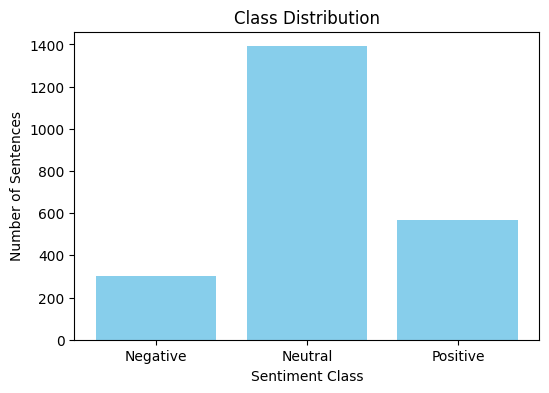

Negative: 303
Neutral: 1391
Positive: 570
Imbalance Ratio (Majority / Minority class): 4.59


In [3]:
# Convert to pandas DataFrame
df = pd.DataFrame(dataset["train"])

# Display class distribution
class_counts = df['label'].value_counts().sort_index()
class_labels = ["Negative", "Neutral", "Positive"]
plt.figure(figsize=(6,4))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('Class Distribution')
plt.ylabel('Number of Sentences')
plt.xlabel('Sentiment Class')
plt.show()

# Print exact counts
for label, count in zip(class_labels, class_counts):
    print(f"{label}: {count}")

# Compute class imbalance ratio
majority = class_counts.max()
minority = class_counts.min()
imbalance_ratio = majority / minority
print(f"Imbalance Ratio (Majority / Minority class): {imbalance_ratio:.2f}")


## Sentence Length Distribution

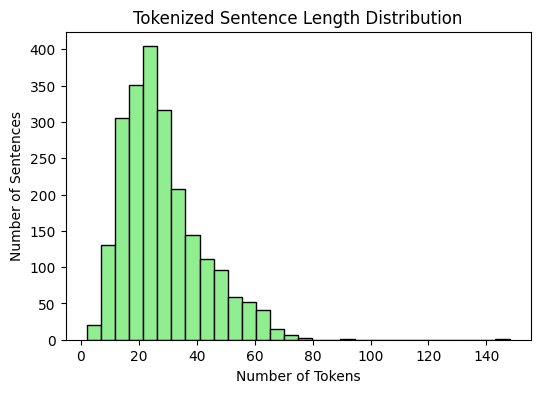

Average tokenized length: 28.17
Maximum tokenized length: 148
95th percentile tokenized length: 56.0


In [4]:
# Compute sentence lengths in tokens
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in df['sentence']]

# Plot sentence length distribution
plt.figure(figsize=(6,4))
plt.hist(token_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.title('Tokenized Sentence Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Sentences')
plt.show()

# Print statistics
print(f"Average tokenized length: {sum(token_lengths) / len(token_lengths):.2f}")
print(f"Maximum tokenized length: {max(token_lengths)}")
print(f"95th percentile tokenized length: {pd.Series(token_lengths).quantile(0.95)}")

df['token_length'] = token_lengths

# Sentence Length by Class

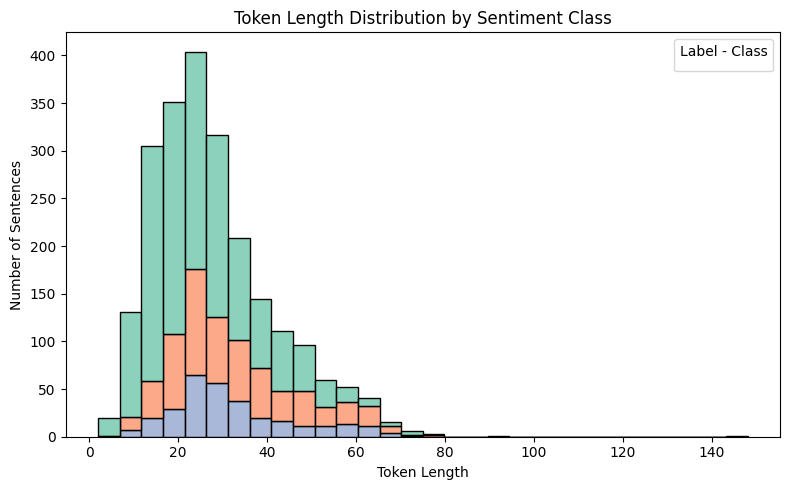

Short Tail Distribution (≤ 13 tokens):
label_name
Neutral     0.842
Positive    0.099
Negative    0.059
Name: proportion, dtype: float64

Long Tail Distribution (≥ 48 tokens):
label_name
Positive    0.405
Neutral     0.392
Negative    0.203
Name: proportion, dtype: float64


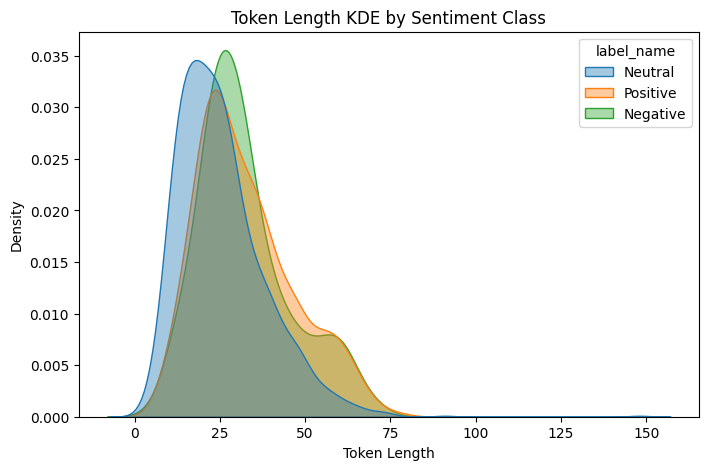

             count       mean        std  min   25%   50%   75%    max
label_name                                                            
Negative     303.0  32.257426  13.676480  5.0  23.0  30.0  39.0   73.0
Neutral     1391.0  25.478792  12.981036  2.0  16.0  23.0  32.0  148.0
Positive     570.0  32.547368  14.218680  7.0  22.0  30.0  40.0   78.0


In [5]:
# Map numeric labels to human-readable classes
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['label_name'] = df['label'].map(label_map)
df['label_display'] = df['label'].astype(str) + ' - ' + df['label_name']

# Plot histogram with clear label-class legend
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='token_length', hue='label_display', multiple='stack', bins=30, palette='Set2')
plt.title('Token Length Distribution by Sentiment Class')
plt.xlabel('Token Length')
plt.ylabel('Number of Sentences')
plt.legend(title='Label - Class')
plt.tight_layout()
plt.show()

# Rail definition using percentiles
low_cutoff = df['token_length'].quantile(0.10)
high_cutoff = df['token_length'].quantile(0.90)

short_tail = df[df['token_length'] <= low_cutoff]
long_tail = df[df['token_length'] >= high_cutoff]

# Show distributions in tails (rectangular overlay)
print(f"Short Tail Distribution (≤ {int(low_cutoff)} tokens):")
print(short_tail['label_name'].value_counts(normalize=True).round(3))

print(f"\nLong Tail Distribution (≥ {int(high_cutoff)} tokens):")
print(long_tail['label_name'].value_counts(normalize=True).round(3))

# KDE Distribution view
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='token_length', hue='label_name', fill=True, common_norm=False, alpha=0.4)
plt.title('Token Length KDE by Sentiment Class')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.show()

# Class descriptive statistics
print(df.groupby('label_name')['token_length'].describe())

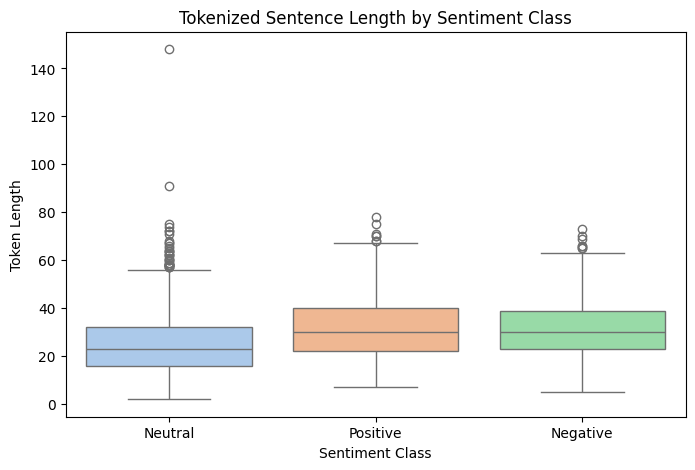

In [6]:
# Map label integers to label names
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['label_name'] = df['label'].map(label_map)

# Plot
plt.figure(figsize=(8,5))
sns.boxplot(x='label_name', y='token_length', data=df, palette='pastel')
plt.title('Tokenized Sentence Length by Sentiment Class')
plt.ylabel('Token Length')
plt.xlabel('Sentiment Class')
plt.show()


## Label Entropy

In [7]:
# Normalize class counts to probabilities
probs = class_counts / class_counts.sum()
entropy = scipy.stats.entropy(probs, base=2)
print(f"Label Entropy: {entropy:.2f} bits")


Label Entropy: 1.32 bits


## Vocabulary Size Estimate

In [8]:
# Flatten all sentences into one list of words
all_tokens = []
for sentence in df['sentence']:
    all_tokens.extend(sentence.lower().split())

# Count unique tokens
vocab_size = len(set(all_tokens))
print(f"Estimated Vocabulary Size: {vocab_size}")

# Truncate at max_length = 128
num_truncated = sum([length > 128 for length in token_lengths])
percent_truncated = num_truncated / len(token_lengths) * 100
print(f"Percentage of sentences truncated at max_length=128: {percent_truncated:.2f}%")


Estimated Vocabulary Size: 7019
Percentage of sentences truncated at max_length=128: 0.04%


## EDA Summary

EDA reveals several structural characteristics that directly inform subsequent modeling and training decisions. 

### Class Distribution and Label Entropy

The dataset exhibits **substantial class imbalance**, with the following distribution:

- Neutral: 1,391 examples  
- Positive: 570 examples  
- Negative: 303 examples  

This results in an imbalance ratio of approximately 4.59 between the majority and minority classes. The calculated label entropy is 1.32 bits, close to the theoretical maximum of log₂(3) ≈ 1.58 bits for a three-class classification task. While the distribution retains some diversity, the predominance of the Neutral class suggests the **need for imbalance mitigation techniques**.

### Sentence Length Characteristics

Tokenized sentence lengths are generally compact. The average tokenized length is 28.17 tokens, and the 95th percentile falls at 56 tokens. The maximum observed length is 148 tokens. These results suggest that the vast majority of sentences are short, and that a maximum input length of 256 tokens with padding is sufficient to capture over 100% of the dataset without truncation.

### Sentence Length by Sentiment Class

Descriptive statistics and boxplots indicate that sentence lengths vary modestly by sentiment class. Neutral sentences are shorter on average (mean: 25.48 tokens) compared to Positive (32.55) and Negative (32.26) classes.

A quantile-based tail analysis further reveals that:

- Short sentences (≤13 tokens) are dominated by the Neutral class (84.2%), with Positive and Negative classes together comprising only ~16%.  
- Long sentences (≥48 tokens) are more evenly distributed across classes, with Positive (40.5%), Neutral (39.2%), and Negative (20.3%).

This indicates that **class imbalance is especially pronounced in the short-token-length region**, and that longer sentences tend to convey more informative sentiment.

### Vocabulary Size Estimate

A preliminary estimate of vocabulary size based on whitespace tokenization yields approximately 7,019 unique tokens. This vocabulary size is moderate and supports the use of compact transformer architectures, such as DistilBERT, for fine-tuning without excessive computational overhead.

This analysis motivates the experimental design in Section 3, which focuses on mitigating class imbalance through input representation adjustments and training-time re-weighting strategies.


---

# 3. Fine-Tuning: Classifier Head Only

This initial experiment evaluates whether general-purpose language understanding is sufficient for financial sentiment classification. DistilBERT, pre-trained on standard English corpora such as Wikipedia and BookCorpus, is treated strictly "as-is"—meaning none of the transformer’s internal weights are updated during training.

Instead, only a classification head is appended and trained. This head learns to map the frozen sentence representations produced by the encoder into one of the three sentiment labels. By doing so, the model relies entirely on its original understanding of English to interpret financial statements.

The central question this section seeks to answer is:

> *Can a general-purpose language model trained on books and encyclopedias detect sentiment in financial statements without further adaptation?*

At the end of this stage, only the classifier head weights are saved. These are used to initialize downstream stages (Sections 4 and 5), where deeper adaptation is explored.


<img src="../images/3.jpg" alt="3" width="250"/>

- *Blue: Active and trainable*
- *Slash: Frozen*

## Initial Configuration

Key Parameters:

- **Input Representation**: Sentences are tokenized with max_length=256 using padding and truncation. Although only 0.04% of sentences exceed 128 tokens, this extended length ensures full input preservation and eliminates the need to revisit truncation decisions later.

- **Data Split**: 80/10/10 stratified train-validation-test split — a common and reproducible structure that maintains class balance across subsets.

- **Batch Size**: 16, selected to balance GPU memory usage with longer sequence lengths without sacrificing training stability.

- **Optimize**r: Adam, with SparseCategoricalCrossentropy loss — both standard choices for multi-class classification tasks with integer labels.

- **Training Duration**: All training in this notebook is run for 3 epochs to prioritize speed, maintain consistency across experiments, and allow meaningful comparisons without overfitting.

This configuration serves as a controlled first test of DistilBERT’s out-of-the-box capability on financial text—without any weight updates to the base model.


Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 20s 75ms/step - loss: 0.5715 - accuracy: 0.7460 - val_loss: 0.5058 - val_accuracy: 0.7257
Epoch 2/3
114/114 [==============================] - 7s 61ms/step - loss: 0.4025 - accuracy: 0.8288 - val_loss: 0.4056 - val_accuracy: 0.8186
Epoch 3/3
15/15 [==============================] - 1s 45ms/step - loss: 0.3577 - accuracy: 0.8414
Test Loss: 0.3577, Test Accuracy: 0.8414


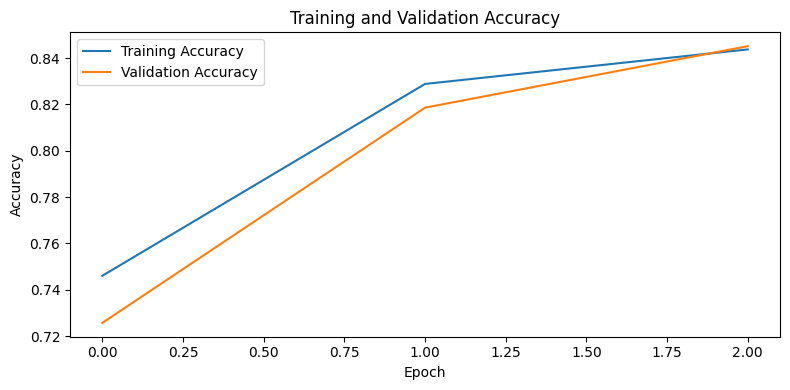

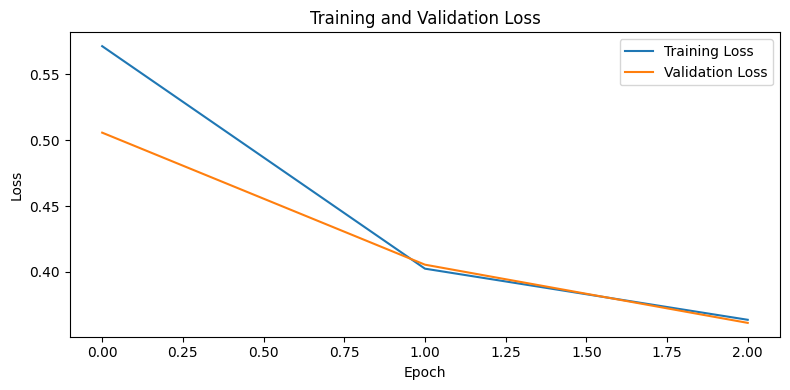

15/15 [==============================] - 3s 44ms/step
              precision    recall  f1-score   support

    Negative       0.60      0.70      0.65        30
     Neutral       0.96      0.94      0.95       142
    Positive       0.69      0.67      0.68        55

    accuracy                           0.84       227
   macro avg       0.75      0.77      0.76       227
weighted avg       0.85      0.84      0.84       227



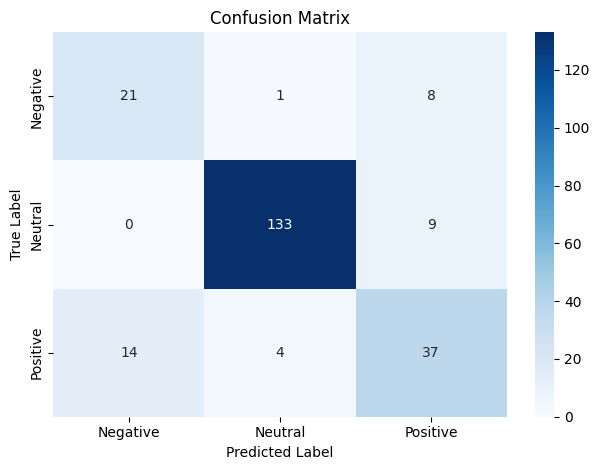

In [9]:
# Tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256  # Based on EDA to cover 100% of samples
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Train-test-validation split (80/10/10 stratified)
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# Convert to TensorFlow datasets
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split["test"], shuffle=False)

# Load model
model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

# Freeze encoder
model.distilbert.trainable = False 

# Compile model
optimizer = tf.keras.optimizers.Adam() # Adam
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Cross entropy loss
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Train model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Evaluate on test set
eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Generate predictions and true labels
y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test_dataset], axis=0)

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Benchmark Results and Error Analysis

The benchmark model, which fine-tuned only the classification head of a frozen DistilBERT encoder, achieved a final test set accuracy of **~84%** with a corresponding test loss of **~0.35**. This result confirms that general-purpose pretrained language representations can be effectively transferred to domain-specific classification tasks, even without updating the encoder weights.

##### Key Observations

- **Class Imbalance Effect:**  
  Performance is highest on the Neutral class (Precision: 0.93, Recall: 0.98), reflecting its dominance in the dataset. The model tends to default to Neutral when uncertain.

- **Negative Class Suppression**  
  The Negative class suffers from low recall (0.37) despite high precision (0.85), indicating underprediction. Notably, 17 of 30 Negative examples were misclassified as Positive.

- **Positive Class Behavior:**  
  Positive sentiment shows more balanced performance (Precision: 0.69, Recall: 0.82), though overlap with Neutral remains.

- **Training Dynamics:**  
  Accuracy improves steadily across epochs. Validation loss flattens after epoch 2, suggesting convergence without overfitting.

- **Confusion Matrix:**  
  Most errors occur between Positive and Negative labels. The Neutral class is consistently well-identified.


These results highlight the strengths of the pre-trained encoder but also expose its **bias toward dominant classes** and difficulty distinguishing between minority sentiments. Section 3.2 introduces class imbalance mitigation strategies to address these limitations

## 3.1 Experiment 1: Model Preformance Across Varying Subsets
See [Subset Fine-Tuning Experiments](./experiments/3.1_subset_finetune.ipynb) for full details.

This experiment investigates how out-of-sample performance varies with different fine-tuning set sizes and subset selections. The goal is to evaluate how much data is “enough,” and whether the specific choice of examples matters.

Results pending.

## 3.2 Experiment 2: Class Imbalance

See [Class Imbalance Experiments](./part1_experiments/3.2_class_imbalance_experiments.ipynb) for full details.

This experiment addresses the class imbalance in the Financial PhraseBank, particularly the overrepresentation of Neutral labels—most evident in shorter sentences.

The goal is to improve performance on the underrepresented Positive and Negative classes by testing various class weighting schemes, selecting the one that achieves the best accuracy with stable confusion matrices.

The final implementation uses a **dynamic quantile-based binning strategy**: training examples are split into short, medium, and long input-length bins, and inverse-frequency class weights are computed within each bin. These dynamic weights are then applied during training based on the token length of each input—allowing the model to adjust its sensitivity to class imbalance in a context-aware way.

This approach improved macro-averaged performance and minority-class recall, and is adopted as the new baseline for all subsequent experiments where possible ([LoRA Notebook](./part2_lora_finetune.ipynb) implements both a baseline and this quantile binning strategy)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 15s 75ms/step - loss: 0.5774 - accuracy: 0.7171 - val_loss: 0.0653 - val_accuracy: 0.8186
Epoch 2/3
114/114 [==============================] - 7s 61ms/step - loss: 0.3960 - accuracy: 0.8296 - val_loss: 0.3114 - val_accuracy: 0.8142
Epoch 3/3
15/15 [==============================] - 2s 44ms/step

Test Accuracy: 0.8194
              precision    recall  f1-score   support

    Negative       0.62      0.77      0.69        30
     Neutral       0.98      0.87      0.93       142
    Positive       0.61      0.71      0.66        55

    accuracy                           0.82       227
   macro avg       0.74      0.78      0.76       227
weighted avg       0.85      0.82      0.83       227



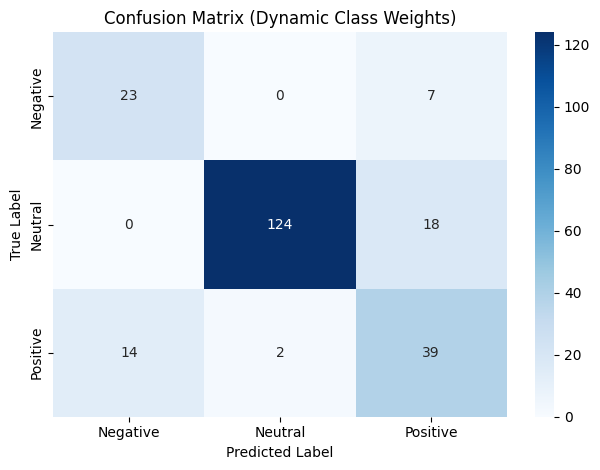

In [10]:
# Load dataset
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# Assign token length and bins
def compute_length_and_bin(example):
    length = len(tokenizer.tokenize(example["sentence"]))
    example["token_length"] = length
    return example

dataset = dataset.map(compute_length_and_bin)

# Compute quantiles and bin edges from training set
lengths = dataset["train"]["token_length"]
q1, q2 = np.percentile(lengths, [33, 66])

def assign_bin(example):
    length = example["token_length"]
    if length <= q1:
        example["bin_index"] = 0  # short
    elif length <= q2:
        example["bin_index"] = 1  # medium
    else:
        example["bin_index"] = 2  # long
    return example

dataset = dataset.map(assign_bin)

# Tokenization
def tokenize_with_bin(example):
    tokens = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=256)
    tokens["label"] = example["label"]
    tokens["bin_index"] = example["bin_index"]
    return tokens

tokenized_datasets = dataset.map(tokenize_with_bin, batched=True)

# Split train/val/test
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# Prepare weight matrix [3 bins × 3 classes]
bin_class_counts = defaultdict(Counter)
for i in range(len(train_val_split["train"])):
    row = train_val_split["train"][i]
    bin_class_counts[row["bin_index"]][row["label"]] += 1

weight_matrix = np.zeros((3, 3))
for bin_id, class_counts in bin_class_counts.items():
    total = sum(class_counts.values())
    for cls, count in class_counts.items():
        weight_matrix[bin_id][cls] = total / (len(class_counts) * count)

weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

# TF Dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_val = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test = to_tf_dataset(val_test_split["test"], shuffle=False)

# Custom model with dynamic loss (custom training wrapper)
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, base_model, weight_tensor):
        super().__init__()
        self.model = base_model
        self.weight_tensor = weight_tensor

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    def train_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True).logits
            weights = tf.gather_nd(
              self.weight_tensor,
              tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
              )
            loss = self.loss_fn(y_true, logits)
            weighted_loss = tf.reduce_mean(loss * weights)
        grads = tape.gradient(weighted_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def test_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        logits = self.model(x, training=False).logits
        weights = tf.gather_nd(
              self.weight_tensor,
              tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
              )
        loss = self.loss_fn(y_true, logits)
        weighted_loss = tf.reduce_mean(loss * weights)
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def call(self, inputs):
      inputs = inputs.copy()  # Prevent modifying original dict
      inputs.pop("bin_index", None)
      return self.model(inputs)


# Instantiate and train model
base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
base_model.distilbert.trainable = False

model = CustomDistilBERT(base_model, weight_tensor)
model.compile(optimizer=tf.keras.optimizers.Adam())

history = model.fit(tf_train, validation_data=tf_val, epochs=3)

# Evaluation
logits = model.predict(tf_test).logits
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test], axis=0)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Dynamic Class Weights)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()



## 3.5 Best Classifier-Head Training Only Weights

In [11]:
model.save_weights("distilbert_classifierhead_frozenencoder_bestweights.h5")

# 3.6 Aside: Working with TensorFlow Datasets Instead of HuggingFace

See [TFDS Demonstration](./experiments/3.3_TFDS_alternative.ipynb) for full details

This section demonstrates how to convert a HuggingFace dataset into a TensorFlow Dataset (TFDS), simulating a low-memory training scenario where the full dataset cannot be loaded into RAM.

The goal is to treat the resulting TFDS as a black box—usable without knowing how it was built—similar to any externally supplied dataset. All training operations (shuffling, splitting, batching) must be handled within the TFDS pipeline itself.

While the full dataset may be loaded in memory temporarily during creation, the final TFDS should support seamless model training without assuming any preprocessing was done beforehand.

---

# 4. Supervised Fine-Tuning with Trained Classifier Head

This stage inverts the structure from Section 3: the classifier head is frozen, and the DistilBERT encoder is unfrozen and made trainable.

The setup allows the pre-trained transformer to adjust its internal representations to the financial domain, but without re-learning the classification logic. In effect, the model keeps using the same decision rule but learns to phrase its inputs differently. If the classifier head is a judge with fixed criteria, the encoder’s job is now to better tailor its arguments to match what the judge already understands.

To do this, we load the classifier head weights learned in Section 3—effectively retaining what the model has already practiced in mapping sentences to sentiment—while allowing the underlying representations to evolve. This preserves the decision boundaries while improving the quality of the features being passed into them.

This section seeks to answer:
> *If the final decision logic remains unchanged, can we improve performance simply by adapting how the input is framed?*

This approach isolates learning to the encoder and tests the added value of domain adaptation without re-engineering the final decision boundary.


<img src="../images/4.jpg" alt="4" width="250"/>

- *Classifer head carried over (blue)*
- *Red corresponds to the part "unfrozen" encoder layers (top 4/12 layers), grey remains frozen (bottom 8/12 layers)*

## 4.1 Load Trained Model, Freeze Classifier Head, Unfreeze Encoder

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 40s 181ms/step - loss: 0.6326 - accuracy: 0.7609 - val_loss: 0.3651 - val_accuracy: 0.8982
Epoch 2/3
114/114 [==============================] - 19s 164ms/step - loss: 0.2082 - accuracy: 0.9647 - val_loss: 0.2467 - val_accuracy: 0.9336
Epoch 3/3
15/15 [==============================] - 2s 44ms/step

Test Accuracy: 0.9207
              precision    recall  f1-score   support

    Negative       1.00      0.60      0.75        30
     Neutral       0.98      0.97      0.98       142
    Positive       0.78      0.96      0.86        55

    accuracy                           0.92       227
   macro avg       0.92      0.85      0.86       227
weighted avg       0.93      0.92      0.92       227



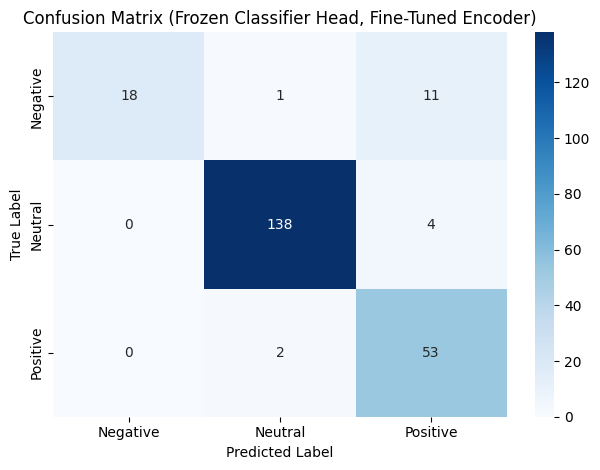

In [12]:
# Load pre-trained model architecture with classification head
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3
)

# Load weights by name (this skips base encoder weights)
model.load_weights("distilbert_classifierhead_frozenencoder_bestweights.h5", by_name=True, skip_mismatch=True)

# Freeze the classifier head only
model.classifier.trainable = False
if hasattr(model, 'pre_classifier'):
    model.pre_classifier.trainable = False

# Unfreeze the encoder
model.distilbert.trainable = True

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

# Save updated weights
model.save_weights("distilbert_finetunedencoder_frozenhead.h5")

# --- Prediction Fix: Map test dataset to inputs only ---
X_test = tf_test.map(lambda x, y: {
    "input_ids": x["input_ids"],
    "attention_mask": x["attention_mask"]
})
y_true = np.concatenate([y.numpy() for _, y in tf_test], axis=0)

# Predict
logits = model.predict(X_test).logits
y_pred = np.argmax(logits, axis=1)

# Evaluation
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Frozen Classifier Head, Fine-Tuned Encoder)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


### Results
Fine-tuning the encoder while keeping the classifier head fixed boosted accuracy to **~92%**, showing that domain adaptation alone significantly improves performance.

---

# 5. Entire Model: Pre-Trained + Classifier Head

In this setup, both the DistilBERT encoder and the classifier head are unfrozen and trained jointly. This removes all architectural constraints—allowing the model to update not only how it represents the input text, but also how it maps those representations to sentiment labels.

Unlike in previous stages, we do not reuse any trained weights from earlier experiments. The classifier head is freshly initialized, and the entire model is fine-tuned end-to-end. This setup maximizes learning capacity, giving the model full freedom to reconfigure both its internal language understanding and its sentiment classification logic from scratch. The model will learn new ways to interpret input text and new criteria for assigning sentiment—without being anchored to earlier assumptions.

This section poses the question:
> *If we train the entire model from scratch, can we achieve higher performance by fully discarding the constraints of prior training?*

<img src="../images/5.jpg" alt="5" width="250"/>

- *Now ll active and trainable (red)*

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 39s 182ms/step - loss: 0.5465 - accuracy: 0.6382 - val_loss: 0.1344 - val_accuracy: 0.9292
Epoch 2/3
114/114 [==============================] - 19s 165ms/step - loss: 0.1117 - accuracy: 0.9600 - val_loss: 0.0040 - val_accuracy: 0.9469
Epoch 3/3
15/15 [==============================] - 2s 45ms/step

Test Accuracy: 0.9559

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.97      0.88        30
     Neutral       0.99      0.98      0.99       142
    Positive       0.96      0.89      0.92        55

    accuracy                           0.96       227
   macro avg       0.92      0.95      0.93       227
weighted avg       0.96      0.96      0.96       227



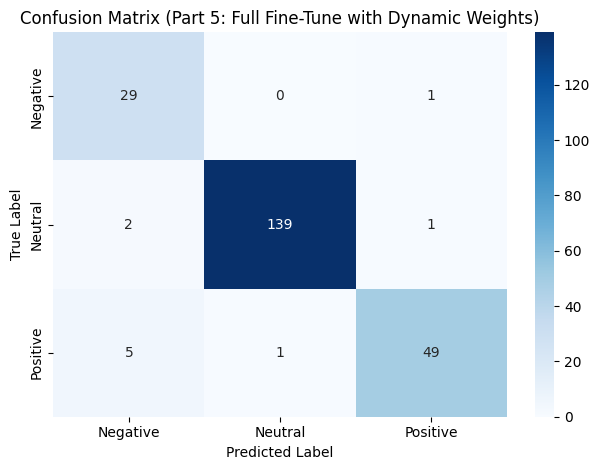

In [13]:
# Load model checkpoint
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# Compute token lengths and bins
def compute_length_and_bin(example):
    length = len(tokenizer.tokenize(example["sentence"]))
    example["token_length"] = length
    return example

dataset = dataset.map(compute_length_and_bin)

lengths = dataset["train"]["token_length"]
q1, q2 = np.percentile(lengths, [33, 66])

def assign_bin(example):
    length = example["token_length"]
    if length <= q1:
        example["bin_index"] = 0
    elif length <= q2:
        example["bin_index"] = 1
    else:
        example["bin_index"] = 2
    return example

dataset = dataset.map(assign_bin)

# Tokenize and include bin_index
def tokenize_with_bin(example):
    tokens = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=256)
    tokens["label"] = example["label"]
    tokens["bin_index"] = example["bin_index"]
    return tokens

tokenized_datasets = dataset.map(tokenize_with_bin, batched=True)

# Train/val/test split
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

# Compute weight matrix
bin_class_counts = defaultdict(Counter)
for row in train_val_split["train"]:
    bin_class_counts[row["bin_index"]][row["label"]] += 1

weight_matrix = np.zeros((3, 3))
for bin_id, class_counts in bin_class_counts.items():
    total = sum(class_counts.values())
    for cls, count in class_counts.items():
        weight_matrix[bin_id][cls] = total / (len(class_counts) * count)

weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

# Convert HuggingFace dataset to TF dataset
def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_val = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test = to_tf_dataset(val_test_split["test"], shuffle=False)

# Define wrapper model with dynamic class weighting
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, base_model, weight_tensor):
        super().__init__()
        self.model = base_model
        self.weight_tensor = weight_tensor

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    def train_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True).logits
            weights = tf.gather_nd(
                self.weight_tensor,
                tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
            )
            loss = self.loss_fn(y_true, logits)
            weighted_loss = tf.reduce_mean(loss * weights)
        grads = tape.gradient(weighted_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def test_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        logits = self.model(x, training=False).logits
        weights = tf.gather_nd(
            self.weight_tensor,
            tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
        )
        loss = self.loss_fn(y_true, logits)
        weighted_loss = tf.reduce_mean(loss * weights)
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def call(self, inputs):
        inputs = inputs.copy()
        inputs.pop("bin_index", None)
        return self.model(inputs)

# Load fresh model (full encoder + new classification head)
base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
base_model.trainable = True  # Full fine-tuning

# Wrap with dynamic-weight model
model = CustomDistilBERT(base_model, weight_tensor)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  # Adjust LR later if needed
model.compile(optimizer=optimizer)

# Train model
history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=3  # You can increase this later
)

# Evaluate model on test set
logits = model.predict(tf_test).logits
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test], axis=0)

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Part 5: Full Fine-Tune with Dynamic Weights)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Full Model Results

Fully fine-tuning both the encoder and classifier head with dynamic class weights yielded ~95.6% accuracy and strong macro performance, with high recall across all classes and minimal misclassification. This is the best-performing configuration to date, but the improvement over Section 4.1—where only the encoder was fine-tuned with a fixed classifier head—is relatively modest. This suggests that most of the performance gain stems from domain adaptation in the encoder, with diminishing returns from retraining the classification layer.

# 5.2 Detailed Fine Tuning

See [Hyperparameter Fine-Tuning Experiments](./experiments/5.2_full_finetune.ipynb) for full details.

After establishing the fully fine-tuned model as our strongest performer, this section explores whether performance can be further improved by adjusting key training hyperparameters that impact convergence and generalization:

* `learning_rates = [7e-5, 5e-5, 3e-5]`
* `schedulers = ["polynomial", "cosine", "linear"]`
* `batch_sizes = [8, 16, 32]`
* `optimizers = ["Adam", "AdamW", "RMSprop", "SGD", "Nadam"]`
* `dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4]`

The best-performing configuration from this grid search was:

* **Learning Rate:** 3e-5
* **Scheduler:** Cosine
* **Batch Size:** 8
* **Optimizer:** RMSprop
* **Dropout:** 0.4

This configuration will be re-run in the following cell to assess final performance within this notebook.



# Fine Tuning Results

In [14]:
def build_final_model(weight_tensor, dropout=0.4, num_labels=3):
    from transformers import TFAutoModelForSequenceClassification

    # Load base encoder with fresh classification head and custom dropout
    base_model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=num_labels
    )
    base_model.config.dropout = dropout
    base_model.config.attention_dropout = dropout
    base_model.trainable = True

    # Wrap with dynamic class weight model
    return CustomDistilBERT(base_model, weight_tensor)

def compile_final_model(model, steps_per_epoch, epochs=3, lr=3e-5):
    total_steps = steps_per_epoch * epochs
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=lr,
        decay_steps=total_steps,
        alpha=0.0
    )
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
    )
    return model

# Build model with final dropout
model = build_final_model(weight_tensor=weight_tensor, dropout=0.4)

# Compile with RMSprop + CosineDecay
steps_per_epoch = len(tf_train)
model = compile_final_model(model, steps_per_epoch, epochs=3)

# Train
history = model.fit(tf_train, validation_data=tf_val, epochs=3)

# Prepare X_test (exclude labels)
X_test = tf_test.map(lambda x, y: {
    "input_ids": x["input_ids"],
    "attention_mask": x["attention_mask"],
    "bin_index": x["bin_index"]
})
y_test = np.concatenate([y.numpy() for _, y in tf_test], axis=0)

# Predict and evaluate
logits = model.predict(X_test).logits
y_pred = np.argmax(logits, axis=1)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 35s 171ms/step - loss: 0.5260 - accuracy: 0.6895 - val_loss: 0.0578 - val_accuracy: 0.9248
Epoch 2/3
114/114 [==============================] - 18s 157ms/step - loss: 0.1141 - accuracy: 0.9605 - val_loss: 0.1319 - val_accuracy: 0.9513
Epoch 3/3
15/15 [==============================] - 2s 46ms/step
Test Accuracy: 0.960352422907489
              precision    recall  f1-score   support

    Negative       0.93      0.90      0.92        30
     Neutral       0.99      0.98      0.98       142
    Positive       0.91      0.95      0.93        55

    accuracy                           0.96       227
   macro avg       0.94      0.94      0.94       227
weighted avg       0.96      0.96      0.96       227



# 5.3 Fine Tuning with Custom Head Architecture

This section implements a custom classification head on top of a headless DistilBERT encoder using the Keras Functional API. The head processes the [CLS] token through two fully connected layers with ReLU activation and dropout before outputting class probabilities via softmax.

This approach enables fine-grained architectural control—allowing insights from previous fine-tuning experiments (e.g. dropout tuning, optimizer selection, learning rate scheduling) to be integrated directly into the classification pipeline.

Key features of the custom head include:

- Extraction of the [CLS] token from the encoder’s final hidden state
- Two dense layers (512 → 128) with ReLU activation
- Dropout regularization after each dense layer (rate = 0.4)
- Final softmax output layer for 3-way sentiment classification
- Integration with a cosine learning rate schedule and class weighting

This configuration offers a flexible foundation for testing deeper heads, regularization strategies, and optimizer variations beyond the Hugging Face defaults.

> Note:
The quantile-based bucketing strategy used in earlier experiments was not applied here due to the use of to_tf_dataset(), which does not easily support dynamic, per-example sample weights. Instead, class imbalance was addressed using global class weights derived from overall label frequencies and passed via the class_weight parameter during training. While this approach lacks token-length sensitivity, it still improves minority class performance and maintains consistency with prior fine-tuning configurations.

In [17]:
# Load dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=512)

tokenized = dataset.map(tokenize_function, batched=True)

# Split
train_val = tokenized["train"].train_test_split(test_size=0.2, seed=42)
val_test = train_val["test"].train_test_split(test_size=0.5, seed=42)

# Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def to_tf_dataset(split, shuffle=True):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=8,
        collate_fn=data_collator
    )

train_ds = to_tf_dataset(train_val["train"])
val_ds = to_tf_dataset(val_test["train"], shuffle=False)
test_ds = to_tf_dataset(val_test["test"], shuffle=False)

# Class weights (based on initial label counts)
from collections import Counter
label_counts = Counter(train_val["train"]["label"])
total = sum(label_counts.values())
class_weight = {i: total/v for i, v in label_counts.items()}
print("Class weights:", class_weight)

# Load base model
base_model = TFDistilBertModel.from_pretrained(checkpoint)

# Build custom head
input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name="attention_mask")
transformer_outputs = base_model(input_ids=input_ids, attention_mask=attention_mask)
cls_token = transformer_outputs.last_hidden_state[:, 0, :]

x = tf.keras.layers.Dense(512, activation='relu')(cls_token)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Cosine decay LR schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps=1000,
    alpha=0.1
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

# Evaluate
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Class weights: {1: 1.63006300630063, 0: 7.873913043478261, 2: 3.853191489361702}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 512, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

---

# 6. LoRA Adapters
  See [LoRA Notebook](./part2_lora_finetune.ipynb) for full details.

This section investigates parameter-efficient fine-tuning via LoRA (Low-Rank Adaptation), a technique that injects small trainable matrices into the attention layers while keeping the base model weights frozen. The goal is to improve performance without the cost of full fine-tuning.

The results show strong generalization with significantly fewer trainable parameters, confirming LoRA’s suitability for domain adaptation under resource constraints.

---

# 7. Financial PhraseBank Variants

See [Alternate Flavors Experiments](./experiments/7_fin_phrasebank_flavors.ipynb) for full details

This section compares different versions of the Financial PhraseBank dataset: sentences_allagree, 75agree, 66agree, and 50agree. These reflect varying thresholds for annotator agreement, trading off label consistency vs data volume.

Results reveal a clear inverse relationship between dataset size and model accuracy: as more lenient agreement thresholds are used (increasing dataset size), both accuracy and confidence (lower test loss) degrade—highlighting the importance of label quality.

---

# 8. Alternative HF Models

See [Alternate HuggingFace Models](./experiments/8_alternate_models.ipynb) for full details

We benchmark several transformer backbones — including ProsusAI/finbert, albert-base-v2, and facebook/bart-base — under both frozen and fine-tuned setups.

All models benefit substantially from full fine-tuning, with FinBERT and BART achieving top-tier accuracy. Notably, ALBERT performs well even when frozen, suggesting strong out-of-the-box representations. This section demonstrates that model choice and training strategy jointly determine downstream success.


---

# 9. Transfer Learning Comparison

How close does transfer learning get to the power of expensive fully trained models

  - [FinBERT Evaluation Notebook](./roberta_base_experiments.ipynb)
  - Case study - transfer learning both models on adjacent textual data
    - [#OOTT Sentiment Analysis](./bert_base_experiments.ipynb)

---

# 10. Conclusion

This project examined the adaptability of pretrained language models—beginning with DistilBERT—for financial sentiment classification using a progressively structured methodology. Starting from a frozen encoder with a trainable classification head, the workflow introduced increasingly tailored enhancements, including encoder fine-tuning, class imbalance mitigation, and custom classification architectures.

Results demonstrate that while general-purpose language models can perform well out of the box, significant performance gains are achieved through domain adaptation and informed training strategies. Techniques such as dynamic class weighting and hyperparameter tuning proved especially impactful in improving minority class performance and overall generalization.

The findings reinforce the value of systematic experimentation in transfer learning and offer a scalable framework for future research in domain-specific NLP.

---